In [1]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd
import pickle
import xgboost as xgb
import polars
import os
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import polars
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, roc_auc_score


import sys
import os

sys.path.append('scripts')

In [2]:
kdprov = '32'

In [2]:
# Parameters
kdprov = 16


In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/fulldataset_VH.pkl', 'rb') as file:
    dt_full=pickle.load(file).to_pandas()

In [5]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl', 'rb') as file:
    xg_dt=pickle.load(file)

In [6]:
cluster=np.sort(dt_full.cluster_data.unique())

In [ ]:
dict_predict={}
for cl in cluster:
    print('Predicting for cluster:',cl)
    start_time = time()
    dt_cl=dt_full.query('cluster_data==@cl')
    y = dt_cl.observation
    X = dt_cl.loc[:,'VH_30':'VH_0']
    X['nth'] = dt_cl.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    model=xg_dt[cl]['model']
    dtest = xgb.DMatrix(X, enable_categorical=True)
    y_pred_prob=model.predict(dtest)
    y_pred=y_pred_prob.argmax(axis=1)
    dt_pred=dt_cl[['idpoint', 'idsubsegment', 'idsegment','periode', 'observation','idkabkota', 'cluster_data']]
    dt_pred['prediction']=y_pred
    score={}
    score['accuracy']=accuracy_score(y, y_pred)
    score['f1_macro']=f1_score(y, y_pred, average='macro')
    score['f1_micro']=f1_score(y, y_pred, average='micro')
    score['auc']=roc_auc_score(y,y_pred_prob, multi_class='ovr')
    score['acc_generative']=akurasi_kelas_generatif(y, y_pred)
    score['acc_fase_padi']=akurasi_fase_padi(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    score['relative_acc']=relative_acc
    print(score)
    print(cm)
    end_time = time()
    elapsed_time = end_time - start_time
    print('Finish with processed time:',elapsed_time)
    dict_predict[cl]={'data_prediction':dt_pred,
                        'score':score,
                    'time':elapsed_time}

Predicting for cluster: 0
{'accuracy': 0.5315673011378533, 'f1_macro': 0.4641189337663011, 'f1_micro': 0.5315673011378533, 'auc': 0.7930194639693585, 'acc_generative': 0.42774352651048086, 'acc_fase_padi': 0.4075782945736434, 'relative_acc': 95.33827314023179}
[[ 33467   3643    957   1358   3557  11162  37781]
 [  2401  21068   3347    708    394   5301  13406]
 [   960   3408  12972   3888    511   1181  11680]
 [  1171    238   2996  17345   3975   1454  13371]
 [  5731    325    178   2907  14337   2270  13727]
 [  2777   2810    246    163    551  13221   5882]
 [ 12897   5376   3863   4371   6470  23945 141028]]
Finish with processed time: 12.443912506103516
Predicting for cluster: 1


{'accuracy': 0.4208654930188188, 'f1_macro': 0.3731371365662266, 'f1_micro': 0.4208654930188188, 'auc': 0.7370879093782108, 'acc_generative': 0.2843033052495139, 'acc_fase_padi': 0.31505555555555553, 'relative_acc': 82.10966609498037}
[[ 97259   6591   2367   2928  24658  44091  51656]
 [  8900  34435   4238   2060   8101  30750  21666]
 [  5661  11067  20043   8293  11098  18713  20175]
 [  7659   1890   6134  32901  26088  17055  23998]
 [ 11359   1068    554   6081  43054  12623  18336]
 [  9659   5706    606   1130   4328  40077  12794]
 [ 42632  16917   7763  14369  48100  87938 217531]]
Finish with processed time: 43.56243276596069
Predicting for cluster: 2


{'accuracy': 0.5088549393329076, 'f1_macro': 0.44851792448993144, 'f1_micro': 0.5088549393329076, 'auc': 0.8265887037036352, 'acc_generative': 0.5271487039563438, 'acc_fase_padi': 0.4875353218210361, 'relative_acc': 92.48198818100866}
[[ 74253   1853   6341   5089  13300  15051  26988]
 [  2087  10895   6815   2186   2084   8731   4327]
 [   921   1355  13190   2444    497    699   2119]
 [  2193    411   5201  19320   4569    598   4358]
 [  3442    197   1081   3615  18707    960   4398]
 [  3084   1683   1019    515    967  15791   2791]
 [ 33947   3752  15099  13035  18160  21994 106813]]
Finish with processed time: 18.830788612365723
Predicting for cluster: 3


{'accuracy': 0.4804576338462257, 'f1_macro': 0.4271480388199664, 'f1_micro': 0.4804576338462257, 'auc': 0.7507155506633078, 'acc_generative': 0.3561928306551298, 'acc_fase_padi': 0.3376030176601703, 'relative_acc': 95.04880876995321}
[[127423   5556   1561   3322  12176   5389  98173]
 [ 10050  42611   4023   1909   2435   3580  52442]
 [  6270  11177  21780   9103    982    246  38667]
 [  7046    987   6611  43224  10432    281  52769]
 [ 14743   2953    261   7354  40061    704  44724]
 [ 13783   9000    568   1419   6263  15230  35687]
 [ 51667   5491   2166   5624   7178   1515 224109]]
Finish with processed time: 21.25667905807495
Predicting for cluster: 4


{'accuracy': 0.48010638590570176, 'f1_macro': 0.39489367066778935, 'f1_micro': 0.48010638590570176, 'auc': 0.7659325083738237, 'acc_generative': 0.24613391789557593, 'acc_fase_padi': 0.346193375296667, 'relative_acc': 92.55153365314726}
[[755243  51448  18402   8035  22205  24364  71353]
 [ 65873 155197  21995   3793   4870  16986  15561]
 [ 50106  57707  59992  14413   5288   1085  12409]
 [ 90475  12901  37046  61755  30576   2298  15849]
 [121002   9662   5539  13418  58552   9964  14788]
 [ 70052  39946   4587   1215   7557  51558  10260]
 [353497  45949  21155   9865  13614  10083 166437]]
Finish with processed time: 77.68735575675964


In [ ]:
pivot_kabkota=[]
cm_prediction={}
df_for_estimation=[]
for cl in cluster:
    print('Running for cluster:',cl)
    df_pred=dict_predict[cl]['data_prediction']
    df_pred_dom=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['prediction'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_obs=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['observation'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_dom_obs=df_pred_dom.merge(df_pred_obs).rename(columns={'prediction':'dom_pred'})
    df_pred['idpoint_loc']=df_pred.idpoint.apply(lambda y:y.split('#')[1])
    df_pred_center=df_pred.query('idpoint_loc=="13"')[['idsubsegment', 'idkabkota','periode','prediction']]
    df_pred_center_obs=df_pred_center.merge(df_pred_obs).rename(columns={'prediction':'center_pred'})
    df_pred_subsegment=df_pred_center_obs.merge(df_pred_dom_obs)
    df_for_estimation.append(df_pred_subsegment)
    for idkab in df_pred.idkabkota.unique():
        #print('Get Metrics for Each Point Prediction')
        score={}
        score['idkabkota']=[idkab]
        y=df_pred.query('idkabkota==@idkab')['observation']
        y_pred=df_pred.query('idkabkota==@idkab')['prediction']
        score['accuracy_titik']=[accuracy_score(y, y_pred)]
        score['f1_macro_titik']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_titik']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_titik']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_titik']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_titik']=[relative_acc]
        cm_titik=cm
        
        y=df_pred_dom_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_dom_obs.query('idkabkota==@idkab')['dom_pred']
        
        #print('Get Metrics for Dominant Prediction')
        score['accuracy_dom']=[accuracy_score(y, y_pred)]
        score['f1_macro_dom']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_dom']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_dom']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_dom']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_dom']=[relative_acc]
        cm_dom=cm
        
        #print('Get Metrics for Center Point Prediction')
        y=df_pred_center_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_center_obs.query('idkabkota==@idkab')['center_pred']
        score['accuracy_center']=[accuracy_score(y, y_pred)]
        score['f1_macro_center']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_center']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_center']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_center']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_center']=[relative_acc]
        cm_center=cm
        cm_prediction[idkab]={'point':cm_titik,'dominant':cm_dom,'center':cm_center}
        pivotal_df=pd.DataFrame(score)
        pivot_kabkota.append(pivotal_df)
        #df_for_estimation.append()
pivot_kabkota=pd.concat(pivot_kabkota)
df_for_estimation=pd.concat(df_for_estimation)

Running for cluster: 2


Running for cluster: 3


Running for cluster: 4


In [9]:
cm_prediction

{'1605': {'point': array([[20494,  2147,   570,   816,  2729,  6701, 20068],
         [ 1857, 17347,  2592,   413,   297,  4099,  7620],
         [  732,  2782, 11033,  2480,   288,   720,  7315],
         [  839,   209,  2581, 14667,  2903,   779,  8622],
         [ 3545,   210,   109,  2400, 12010,  1633,  8468],
         [ 2002,  2026,   175,   135,   499,  9981,  3332],
         [ 8914,  4074,  2532,  3139,  3205, 12016, 86120]]),
  'dominant': array([[ 886,   64,   13,   24,   90,  199,  865],
         [  51,  780,   96,   11,    7,  128,  296],
         [  13,   89,  505,   92,    7,   10,  298],
         [  17,    3,   90,  652,  107,   14,  341],
         [ 129,    6,    3,   77,  540,   45,  335],
         [  63,   66,    7,    3,   22,  448,  117],
         [ 265,  131,   75,   91,   80,  236, 3922]]),
  'center': array([[ 865,   93,   18,   34,  107,  261,  763],
         [  63,  736,  101,   19,    8,  159,  283],
         [  30,  104,  461,   98,    9,   29,  283],
       

In [10]:
# cm=cm_prediction['3215']['dominant']
# cm_percentage_by_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
# np.set_printoptions(suppress=True)
# np.round(cm_percentage_by_row,2)

In [11]:
with open(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_pivot_cm.pkl', 'wb') as file:
    pickle.dump({'pivot':pivot_kabkota,'cm':cm_prediction,'df_for_est':df_for_estimation},file)

In [3]:
with open(f"/data/ksa/05_Modelling/metrics_results/{kdprov}_pivot_cm.pkl", 'rb') as f:
    dict_report = pickle.load(f)

In [12]:
cek = pd.DataFrame(dict_report['pivot'])
cek.to_csv('pivot_kabkota_16.csv')

In [12]:
dict_date={
    '2022_03':'2022_01',
    '2022_05':'2022_02',
    '2022_08':'2022_03',
    '2022_10':'2022_04',
    '2022_13':'2022_05',
    '2022_15':'2022_06',
    '2022_18':'2022_07',
    '2022_20':'2022_08',
    '2022_23':'2022_09',
    '2022_25':'2022_10',
    '2022_28':'2022_11',
    '2022_30':'2022_12',
    '2023_03':'2023_01',
    '2023_05':'2023_02',
    '2023_08':'2023_03',
    '2023_10':'2023_04',
    '2023_13':'2023_05',
    '2023_15':'2023_06',
    '2023_18':'2023_07',
    '2023_20':'2023_08',
    '2023_23':'2023_09',
    '2023_25':'2023_10',
    '2023_28':'2023_11',
    '2023_30':'2023_12'
}

In [13]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:dict_date[y])

In [14]:
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')

In [15]:
cm_period={}
acc_fase_period={}
for i in df_for_estimation.periode.unique():
    df_x=df_for_estimation.query('periode==@i')
    y_true=df_x['observation']
    y_pred_center=df_x['center_pred']
    y_pred_dom=df_x['dom_pred']
    cm_center = confusion_matrix(y_true, y_pred_center)
    cm_dom = confusion_matrix(y_true, y_pred_dom)
    cm_center= cm_center.astype('float') / cm_center.sum(axis=1, keepdims=True) * 100
    cm_dom= cm_dom.astype('float') / cm_dom.sum(axis=1, keepdims=True) * 100
    cm=cm_center
    relative_acc_center = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    cm=cm_dom
    relative_acc_dom = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    
    cm_period[i]={'center':cm_center,'dom':cm_dom}
    acc_center=[]
    acc_dom=[]
    for j in range(7):
        acc_center.append(cm_center[j,j])
        acc_dom.append(cm_dom[j,j])
    acc_center.append(accuracy_score(y_true, y_pred_center))
    acc_dom.append(accuracy_score(y_true, y_pred_dom))
    acc_center.append(akurasi_fase_padi(y_true, y_pred_center))
    acc_dom.append(akurasi_fase_padi(y_true, y_pred_dom))
    acc_center.append(relative_acc_center)
    acc_dom.append(relative_acc_dom)
    acc_fase_period[i]={'center':acc_center,'dom':acc_dom}

In [16]:
acc_fase_data=pd.DataFrame(acc_fase_period).T.reset_index()
acc_fase_data['center']=acc_fase_data.center.apply(lambda y: np.array(y))
acc_fase_data['dom']=acc_fase_data.dom.apply(lambda y: np.array(y))

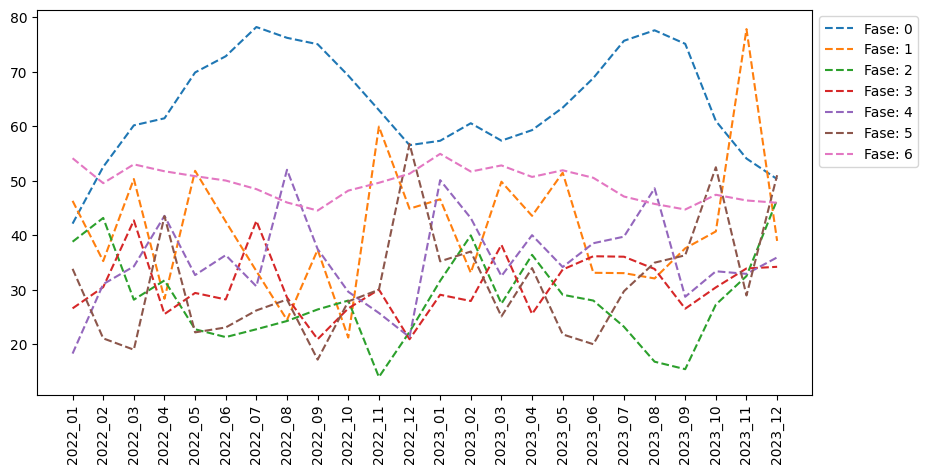

In [17]:
fase0=[]
fase1=[]
fase2=[]
fase3=[]
fase4=[]
fase5=[]
fase6=[]
for i in range(acc_fase_data.shape[0]):
    fase0.append(acc_fase_data['center'][i][0])
    fase1.append(acc_fase_data['center'][i][1])
    fase2.append(acc_fase_data['center'][i][2])
    fase3.append(acc_fase_data['center'][i][3])
    fase4.append(acc_fase_data['center'][i][4])
    fase5.append(acc_fase_data['center'][i][5])
    fase6.append(acc_fase_data['center'][i][6])
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, fase0, linestyle='--', label='Fase: 0', color='tab:blue')
plt.plot(x, fase1, linestyle='--', label='Fase: 1', color='tab:orange')
plt.plot(x, fase2, linestyle='--', label='Fase: 2', color='tab:green')
plt.plot(x, fase3, linestyle='--', label='Fase: 3', color='tab:red')
plt.plot(x, fase4, linestyle='--', label='Fase: 4', color='tab:purple')
plt.plot(x, fase5, linestyle='--', label='Fase: 5', color='tab:brown')
plt.plot(x, fase6, linestyle='--', label='Fase: 6', color='tab:pink')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

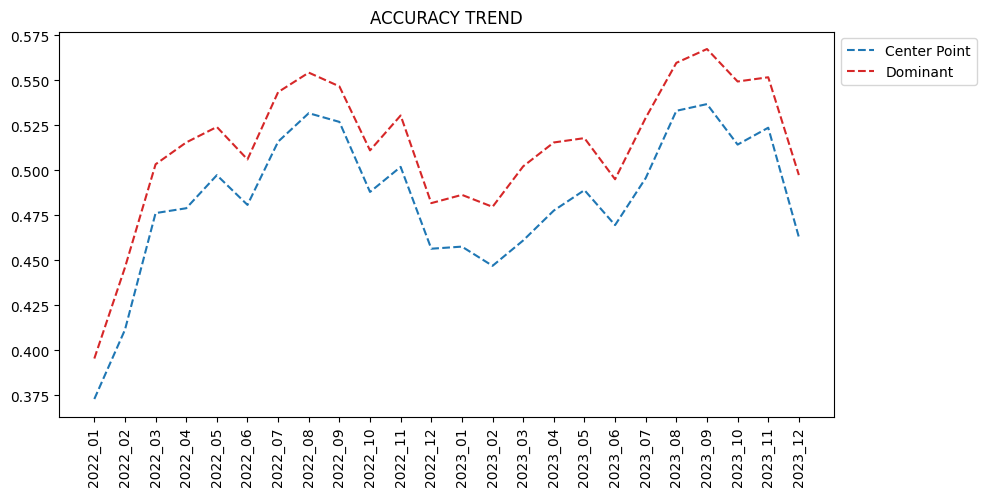

In [18]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][7])
    acc_dom.append(acc_fase_data['dom'][i][7])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

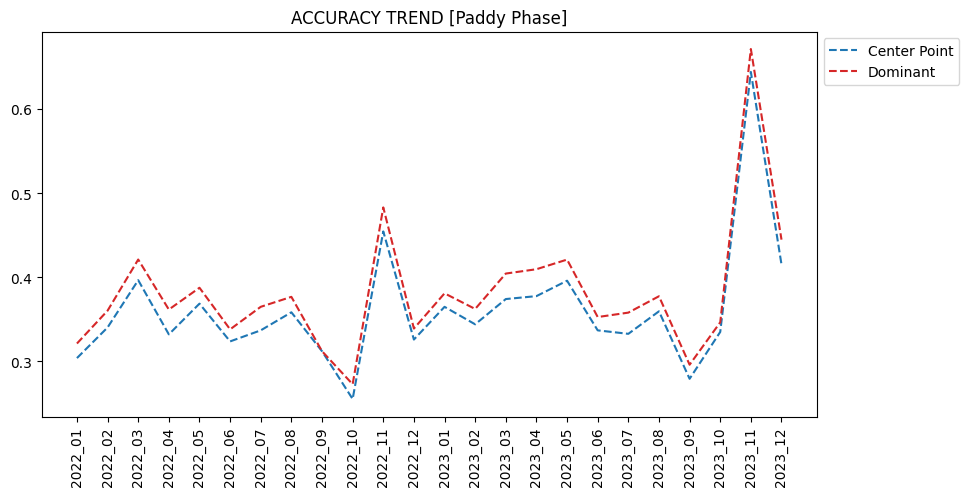

In [19]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][8])
    acc_dom.append(acc_fase_data['dom'][i][8])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_paddy_tred.png', dpi=300, bbox_inches='tight')
plt.show()

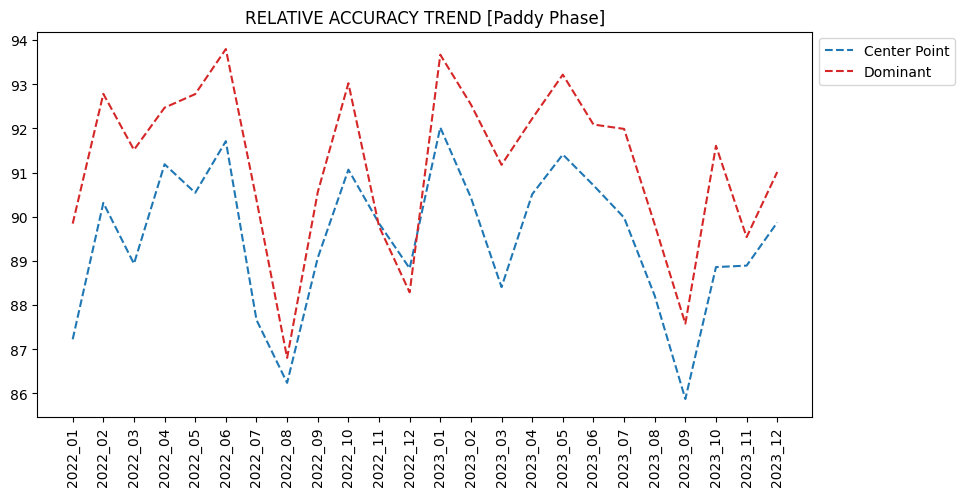

In [20]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][9])
    acc_dom.append(acc_fase_data['dom'][i][9])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('RELATIVE ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_relacc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:y.replace('_',''))
df_for_estimation['id_segmen']=df_for_estimation.idsubsegment.apply(lambda y:y[:9])
df_for_estimation['subsegmen']=df_for_estimation.idsubsegment.apply(lambda y:y[9:])
df_for_estimation['tahun']=df_for_estimation.periode.apply(lambda y: y[:4])
df_for_estimation['bulan']=df_for_estimation.periode.apply(lambda y: y[4:])
df_for_estimation['fase_obs']=df_for_estimation.observation
df_for_estimation['fase_pred']=df_for_estimation.center_pred
df_for_estimation['fase_dom']=df_for_estimation.dom_pred
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')